## Data Dictionary

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - amount of the transaction in local currency.

* nameOrig - customer who started the transaction

* oldbalanceOrg - initial balance before the transaction

* newbalanceOrig - new balance after the transaction

* nameDest - customer who is the recipient of the transaction

* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [28]:
#Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



### Loading and Understanding dataset

In [29]:
# loading data
df=pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [30]:
#Data informaation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [31]:
#Data Description
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [32]:
#different type value counts
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [33]:
#fraud and non fraud value counts
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [34]:
#checking for null values
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

### Data cleaning and preprocessing

### Steps taken in data cleaning and preprocessing 
* Instead of using type (cash-in,cash-out,transfer, payment,debt) as one entity, divided the type into its sub category.
* Marked merchant payments based on the reciever's end.
* Introduced engineered features like errorBalanceOrig and errorBalancedDest
* Found daily and hourly trends
* Dropped irrelavant features

In [35]:
#one-hot encoded variables
df=pd.get_dummies(df,columns=['type'],drop_first=True)

In [36]:
# information regarding merchants
df['Merchant']=df['nameDest'].str.startswith("M").astype(int)

In [37]:
#finding error at sender's and reciever's end
df['errorOrg']=df['oldbalanceOrg']-df['amount']-df['newbalanceOrig']
df['errorDest']=df['oldbalanceDest']+df['amount']-df['newbalanceDest']

In [38]:
# analyzing hourly and daily trends
df['hour']=df['step']%24
df['day']=df['step']//24

In [39]:
# removing irrelavant features and data leaking features
x=df.drop(['isFraud','isFlaggedFraud','nameOrig','nameDest'],axis=1)
y=df['isFraud']

### Data splitting and model fitting
* Splitted data into train test data
* Used Randomforest classifier and XGBoost model
* Defined model evaluation function for model evaluation

In [40]:
#train and test split data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,stratify=y,random_state=3)

In [41]:
Rndforest=RandomForestClassifier(n_estimators=100, class_weight='balanced',random_state=3)
Rndforest.fit(x_train,y_train)
yPred=Rndforest.predict(x_test)

In [42]:
xgb=XGBClassifier(objective='binary:logistic', eval_metric='auc',scale_pos_weight=10,random_state=3)
xgb.fit(x_train,y_train)
yPred_xgb=xgb.predict(x_test)

In [43]:
# define function to evalute metrics
def evaluate_model(y_true,y_pred,name):
    print(f"\n {name} Evaluation:")
    print("Classifciation Report:\n",classification_report(y_true,y_pred))
    print("Confusion Matrix:\n",confusion_matrix(y_true,y_pred))

    print('\nROC-AUC Score:',roc_auc_score(y_true,y_pred))
evaluate_model(y_test,yPred,"RandomForest")
evaluate_model(y_test,yPred_xgb,"XGBoost")



 RandomForest Evaluation:
Classifciation Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       1.00      1.00      1.00      1643

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
 [[1270881       0]
 [      6    1637]]

ROC-AUC Score: 0.9981740718198417

 XGBoost Evaluation:
Classifciation Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.98      0.99      0.99      1643

    accuracy                           1.00   1272524
   macro avg       0.99      1.00      0.99   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion Matrix:
 [[1270852      29]
 [     11    1632]]

ROC-AUC Score: 0.996641055594924


## Why Random Forest Classifier was choosen?
* Random Forest can handle both numbers and categories easily.
* Random Forest has class_weight (class_weight='balanced') that automatically adjusts for imbalanced fraud cases.
* It prevents overfitting as it builds many decision trees and combines them.
* Gives feature importance

## Why XGBoost was Choosen?
* XGBoost can understand complicated relationships in the data
* XGBoost can focus more on the rare fraud cases by adjusting its settings.
* XGBoost is known for being very fast even on huge datasets
* XGBoost can identify whichare most important features for detecting fraud.

*Selected variables by dropping IDs, creating balance and time features, encoding transaction types, and keeping only the features that logically and practically help detect fraud.*

### Model Fine Tuning 

Used different hyperparameters for the model
and found the best one

* Random Forest Fine-Tuning

        rf = RandomForestClassifier(class_weight='balanced', random_state=42)
        rf_params = {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
        }

        rf_grid = GridSearchCV(rf, rf_params, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
        rf_grid.fit(x_train, y_train)


        print("Random Forest Best Parameters:", rf_grid.best_params_)


        y_pred_rf = rf_grid.predict(x_test)
        print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
        print("ROC-AUC:", roc_auc_score(y_test, rf_grid.predict_proba(x_test)[:,1]))

-----------------------------------------------------


* XGBoost Fine-Tuning
        
        xgb = XGBClassifier(objective='binary:logistic', eval_metric='auc', scale_pos_weight=10, random_state=42)
        xgb_params = {
            'n_estimators': [100, 200],
            'max_depth': [4, 6, 8],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1],
            'colsample_bytree': [0.8, 1],
        }

        xgb_grid = GridSearchCV(xgb, xgb_params, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
        xgb_grid.fit(x_train, y_train)

        print("XGBoost Best Parameters:", xgb_grid.best_params_)

        y_pred_xgb = xgb_grid.predict(x_test)
        print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
        print("ROC-AUC:", roc_auc_score(y_test, xgb_grid.predict_proba(x_test)[:,1]))
        
        
*Model fine-tuning could further enhance performance; however, due to limited processing capacity and time constraints on my laptop, it could not be completed.*


Metrics used

Confusion Matrix: shows how many frauds and non-frauds were correctly or incorrectly classified.

Classification Report : gives detailed metrics like precision, recall, and F1-score.

ROC-AUC Score : measures the model’s overall ability to separate fraud and non-fraud cases,

### Feature engineering
* Found the most important features that contributes towards the model output.


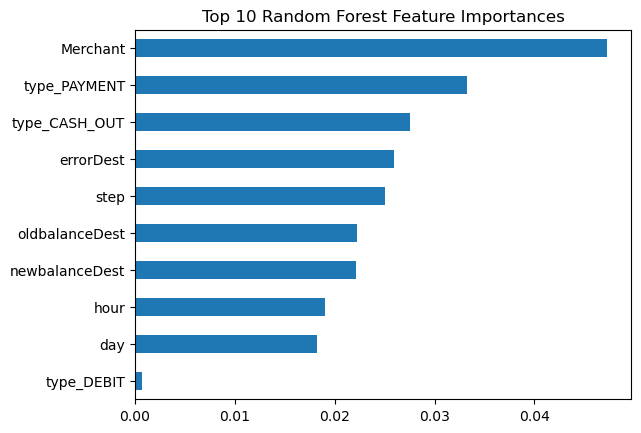

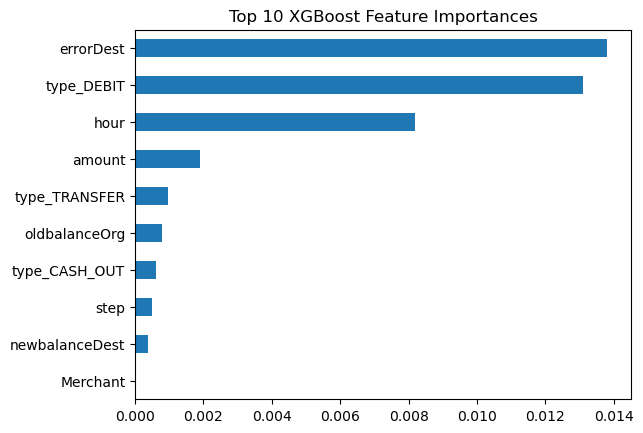

In [44]:
#feature engineering
imp_rndf=pd.Series(Rndforest.feature_importances_,index=x.columns).sort_values(ascending=True)
imp_rndf[:10].plot(kind='barh')
plt.title("Top 10 Random Forest Feature Importances")
plt.show()

imp_xgb=pd.Series(xgb.feature_importances_,index=x.columns).sort_values(ascending=True)
imp_xgb[:10].plot(kind='barh')
plt.title("Top 10 XGBoost Feature Importances")
plt.show()

## Key factors 
* `errorBalanceDest`,
* `Transaction Type (TRANSFER, CASH_OUT)`,
* `Transaction Amount`,
* `Transaction Time (Hour of the Day)`,
* `Sender and Receiver Balance Behavior`

*Frauders change account balances, perform large movements quickly, and use irregular working times when corporate control is inactive.
These are consistent patterns of known financial fraud behavior, and the main predictors of the model make sense and are consistent with businesses.*

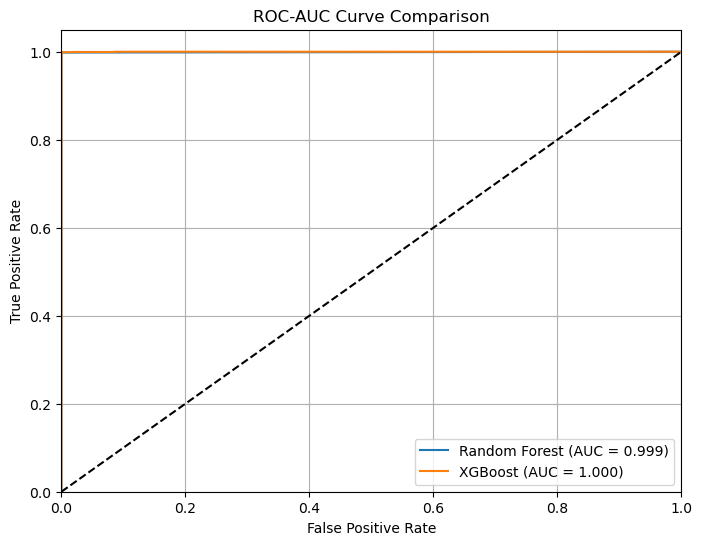

In [45]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for RandomForest
y_proba = Rndforest.predict_proba(x_test)[:,1] 
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
  
#XGBoost 
y_proba_xgb = xgb.predict_proba(x_test)[:,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC Curves
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr, label=f'Random Forest (AUC = {roc_auc:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.3f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve Comparison')
plt.legend(loc="lower right")
plt.grid()
plt.show()


* ROC-AUC measures how well the model can separate fraud cases from normal transactions.
* A higher AUC (closer to 1) means the model is better at correctly ranking frauds higher than genuine transactions.

## Preventions and Actions required

* Real time fraud detection
* Applying smart trancsactions limits
* Encrypting sensitive data
* Updating and checking the model
* Conducting regular external security audits
* Customer feedback collection
